In [1]:
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import seaborn
import matplotlib.pyplot as plt
import os
import sys


box = sys.argv[1]
box = 'Box0_1400'
curr_run_fname = '/oak/stanford/orgs/kipac/aemulus/aemulus_nu/%s/'%(box)
rockstar_dir = curr_run_fname+'output/rockstar/'

f = open(rockstar_dir+'savelist.txt', 'r')
savelist = f.read().split()
f.close()

N_snapshots = len(savelist)

0it [00:00, ?it/s]/tmp/ipykernel_15005/1026838012.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(bin_cnters[Ngt10], N[Ngt10], c=color,
16it [00:32,  2.01s/it]


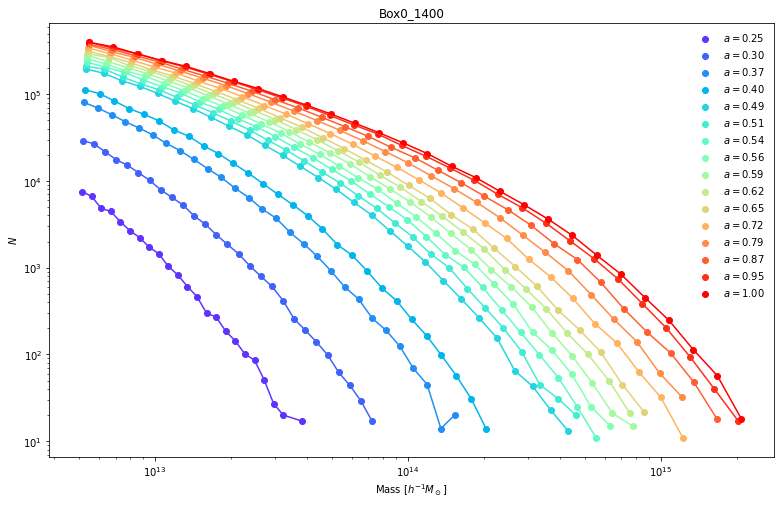

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,8))
i=0

import pickle

NvMs = {}
f = open('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+curr_run_fname.split('/')[-2]+'_M200b', 'r')
for line in tqdm(f):
    snapshot_mass = line.strip().split()
    snapshot_mass = np.array(snapshot_mass, dtype=np.float64)    
    f = open(rockstar_dir+'out_%d.list'%(i), 'r')
    
    vol = -1
    a = -1
    Mpart = -1
    for line in f:
        if('#a' in line):
            a = eval(line.split()[2])
        if('Particle mass' in line):
            Mpart = eval(line.split()[2])
        if('Box size' in line):
            vol = eval(line.split()[2])**3
            break
            
    
    
    nBins = 32
    edges = np.logspace(np.log10(100*Mpart), np.log10(np.max(snapshot_mass)), nBins, 10.)
    
    dM = np.array([edges[i+1]-edges[i] for i in range(len(edges)-1)])
    
    color = plt.colormaps["rainbow"]((i+1)/N_snapshots)[:-1]
    N, bin_edge, bin_idx = binned_statistic(snapshot_mass, np.ones_like(snapshot_mass), 
                                            statistic='count', bins=edges)

    bin_cnters = np.array([np.sqrt(bin_edge[i]*bin_edge[i+1]) for i in range(len(bin_edge)-1)])
    
    Ngt10 = np.where(N>10)
    
    ax.plot(bin_cnters[Ngt10], N[Ngt10], c=color)
    ax.scatter(bin_cnters[Ngt10], N[Ngt10], c=color,
              label=r'$a=%.2f$'%(a))
    
    i+=1
    NvMs[a] = {'M':bin_cnters[Ngt10], 'N':N[Ngt10], 'vol':vol, 'Mpart':Mpart, 'bin_edges':bin_edge,'dM':dM[Ngt10]}

f.close()
ax.set_title(curr_run_fname.split('/')[-2])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Mass $[h^{-1}M_\odot]$')
ax.set_ylabel(r'$N$')
ax.legend(frameon=False)

plt.savefig('figures/'+curr_run_fname.split('/')[-2]+'_NvsM.pdf', bbox_inches='tight')

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+curr_run_fname.split('/')[-2]+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'wb')
pickle.dump(NvMs, NvM_f)
NvM_f.close()